# Solve NFW equations with lenstronomy

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

In [6]:
import astropy, lenstronomy
print(astropy.__version__)
print(lenstronomy.__version__)

6.1.0
1.11.10


In [130]:
cosmology = FlatLambdaCDM(H0=70, Om0=0.3)  # Example values
# Lens and source redshift
z_l = 0.5
z_s = 1
lens_cosmo = LensCosmo(z_lens=z_l, z_source=z_s, cosmo=cosmology )

# NFW profile parameters
M200 = 1e15  # Solar masses

# Empirical mass-concentration relation (Dutton & Macciò 2014)
def concentration(M200, z):
    A = 5.71
    B = -0.084
    C = -0.47
    c200 = A * (M200 / 1e12)**B * (1 + z)**C
    return c200

# Calculate concentration parameter
c200 = concentration(M200, z_l)

# Convert M200 to lensing parameters
Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=M200, c=c200)

rho0, Rs, c, r200, M200 = lens_cosmo.nfw_angle2physical(Rs_angle=Rs_angle, alpha_Rs=alpha_Rs)

In [126]:
lens_model_list = ['NFW']
lens_model = LensModel(lens_model_list, z_lens=z_l, z_source=z_s)
kwargs_nfw = [{'Rs': Rs, 'alpha_Rs': alpha_Rs, 'center_x': 0, 'center_y': 0}]

In [128]:
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
solver = LensEquationSolver(lens_model)
source = einstein_radius_nfw(M200, z_l, z_s, cosmology)*0.6
x_source, y_source = source, source
x_image, y_image = solver.image_position_from_source(
                sourcePos_x=x_source,
                sourcePos_y=y_source,
                kwargs_lens=kwargs_nfw)
mag = lens_model.magnification(x_image, y_image, kwargs_nfw)
dt = lens_model.arrival_time(x_image, y_image, kwargs_nfw)

print(f"Source position: ({x_source}, {y_source})")
print(f"Image position: ({x_image}, {y_image})")
print(f"Magnification: {mag}")
print(f"Time delay: {dt}")


Source position: (9.244964524740519, 9.244964524740519)
Image position: ([-0.73579154 -0.35685298], [-0.73579154 -0.35685298])
Magnification: [-0.04418353  0.0111941 ]
Time delay: [11104.56280268 11119.51200807]


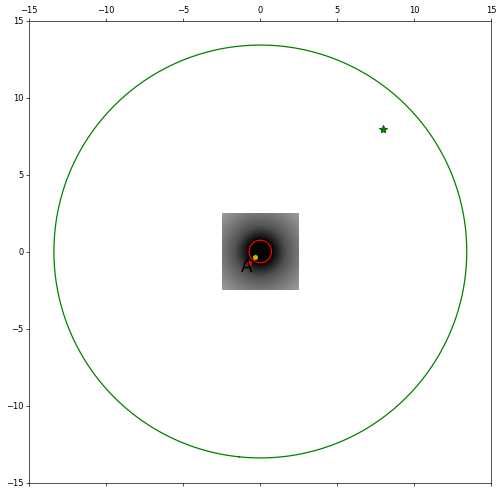

In [120]:
from lenstronomy.Plots import lens_plot

fig, ax = plt.subplots(figsize=(10,10),dpi=60)
beta_ra, beta_dec = 7.935, 7.935
lens_plot.lens_model_plot(ax, 
    lensModel=lens_model,
    kwargs_lens=kwargs_nfw, 
    sourcePos_x=beta_ra, 
    sourcePos_y=beta_dec, 
    point_source=True,
    with_caustics=True,
    fast_caustic=True,
    coord_inverse=True,
)
                      
# image
# add point size to make it visible
plt.plot(x_image[0], y_image[0],marker='.',ls='None', color='r', markersize=10, label='Image 1')
plt.plot(x_image[1], y_image[1],marker='.',ls='None', color='y', markersize=10, label='Image 2')

# # source
plt.plot(beta_ra, beta_dec,marker='*',ls='None', color='g', markersize=10, label='Source')

ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
plt.show()

## To show the size of the custic is related to the einstein radius

* We will sample source position within boundary define by the einstein radius.

In [96]:
# function to get the Einstein radius
def einstein_radius_nfw(M200, zl, zs, cosmo):

    M200 = M200 * u.M_sun.to(u.kg)  # Convert solar mass to kg
    # Constants in SI units
    G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2
    c = 299792458  # speed of light in m/s

    # Calculate critical density
    rho_crit = cosmo.critical_density(zl).to(u.kg / u.m**3).value

    # Calculate r200
    r200 = (3 * M200 / (4 * np.pi * 200 * rho_crit))**(1/3)

    # angular diameter distance
    d_A_L = cosmo.angular_diameter_distance(zl).to(u.m).value
    d_A_S = cosmo.angular_diameter_distance(zs).to(u.m).value
    d_A_LS = cosmo.angular_diameter_distance_z1z2(zl, zs).to(u.m).value

    # sigma_crit
    sigma_crit = c**2 / (4 * np.pi * G) * d_A_S / (d_A_L * d_A_LS)

    # Einstein radius
    # Einstein radius calculation
    theta_E = (M200 / (2 * r200 * sigma_crit * d_A_L))  # radians

    # Convert to arcseconds
    theta_E_arcsec = theta_E * 206265

    return theta_E_arcsec

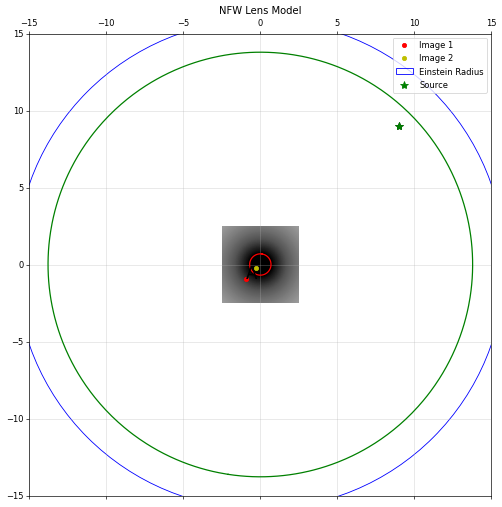

In [97]:
# plot lens_plot with Einstein radius
fig, ax = plt.subplots(figsize=(10,10),dpi=60)
beta_ra, beta_dec = 9, 9
lens_plot.lens_model_plot(ax, 
    lensModel=lens_model,
    kwargs_lens=kwargs_nfw, 
    sourcePos_x=beta_ra, 
    sourcePos_y=beta_dec, 
    point_source=True,
    with_caustics=True,
    fast_caustic=True,
    coord_inverse=True,
)

# image
# add point size to make it visible
plt.plot(x_image[0], y_image[0],marker='.',ls='None', color='r', markersize=10, label='Image 1')
plt.plot(x_image[1], y_image[1],marker='.',ls='None', color='y', markersize=10, label='Image 2')

# circle wrt einsrein radius
theta_E = einstein_radius_nfw(M200, z_l, z_s, cosmology)
circle = plt.Circle((0, 0), theta_E, color='b', fill=False, label='Einstein Radius')
ax.add_artist(circle)

# source
plt.plot(beta_ra, beta_dec,marker='*',ls='None', color='g', markersize=10, label='Source')
# legend
plt.legend()
plt.title('NFW Lens Model')

ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
# show grid
plt.grid(alpha=0.4)
# save figure
plt.savefig('nfw_lens_model2.png')
plt.show()


In [69]:
# to test for multiple source positions
x_source_arr, y_source_arr = np.linspace(0, 15, 1000), np.linspace(0, 15, 1000)
x_image_arr, y_image_arr = [], []
mag_arr = []
for x_source, y_source in zip(x_source_arr, y_source_arr):
    x_image, y_image = solver.image_position_from_source(
                    sourcePos_x=x_source,
                    sourcePos_y=y_source,
                    kwargs_lens=kwargs_nfw)
    x_image_arr.append(list(x_image))
    y_image_arr.append(list(y_image))
    mag = lens_model.magnification(x_image, y_image, kwargs_nfw)
    mag_arr.append(list(mag))

In [70]:
# print magnification and source position
for i in range(len(x_source_arr)):
    print(f"Source position: ({x_source_arr[i]}, {y_source_arr[i]})")
    print(f"Image position: ({x_image_arr[i]}, {y_image_arr[i]})")
    print(f"Magnification: {mag_arr[i]}")
    print("\n")

Source position: (0.0, 0.0)
Image position: ([3.4526567390103997, -3.4526567390103997, 3.4526567390103997, -4.553503814796998, 4.553503814796998, -3.4526567390103997, 4.553503814796998, -4.553503814796998, -4.040744705422042, 4.040744705422042, 4.040744705422042, -4.040744705422042, -3.042102775747364, 4.837442118576165, -4.837442118576165, -3.042102775747364, -4.837442118576165, 3.042102775747364, 4.837442118576165, 3.042102775747364], [4.553503814796998, -4.553503814796998, -4.553503814796998, -3.4526567390103993, -3.4526567390103993, 4.553503814796998, 3.4526567390103993, 3.4526567390103993, -4.040744705422042, -4.040744705422042, 4.040744705422042, 4.040744705422042, -4.837442118576165, -3.0421027757473644, 3.0421027757473644, 4.837442118576165, -3.0421027757473644, -4.837442118576165, 3.0421027757473644, 4.837442118576165])
Magnification: [-191642537334914.72, -191642537334914.72, -191642537334914.72, -200159983438688.72, -200159983438688.72, -191642537334914.72, -200159983438688.

## Cross section

* sample random source positions within the Einstein radius

* check how many of them form multiple images

In [98]:
theta_E = einstein_radius_nfw(M200, z_l, z_s, cosmology)
x_source_arr, y_source_arr = np.random.uniform(0, theta_E, 10000), np.random.uniform(0, theta_E, 10000)
theta_E

15.87777824516417

In [72]:
x_image_arr, y_image_arr = [], []
mag_arr = []
for x_source, y_source in zip(x_source_arr, y_source_arr):
    x_image, y_image = solver.image_position_from_source(
                    sourcePos_x=x_source,
                    sourcePos_y=y_source,
                    kwargs_lens=kwargs_nfw)
    x_image_arr.append(list(x_image))
    y_image_arr.append(list(y_image))
    mag = lens_model.magnification(x_image, y_image, kwargs_nfw)
    mag_arr.append(list(mag))

In [73]:
# check element with two images in x_image_arr
num_images = []

for i in range(len(x_image_arr)):
    num_images.append(len(x_image_arr[i]))
num_images = np.array(num_images)
np.sum(num_images==2)/len(num_images)*100

15.97

In [79]:
7.17*2/3

4.78

## Table

| Einstein radius | SL percentage |
|-----------------|---------------|
| 15.87           | 7.17          |
| 10.65           | 15.97         |


In [34]:
# print magnification and source position
for i in range(len(x_source_arr)):
    print(f"Source position: ({x_source_arr[i]}, {y_source_arr[i]})")
    print(f"Image position: ({x_image_arr[i]}, {y_image_arr[i]})")
    print(f"Magnification: {mag_arr[i]}")
    print("\n")

Source position: (8.8161687046009, 0.026653449415358445)
Image position: ([-0.9094111358698592], [-0.002749373851594085])
Magnification: [-0.07404284315502638]


Source position: (1.2467242319386884, 1.6377660452304688)
Image position: ([4.329739136217251, -2.6688252146253766], [5.687785285765007, -3.50591670972128])
Magnification: [2.51445243688588, -1.2898250751958782]


Source position: (0.5618727373633681, 5.08302603037908)
Image position: ([-0.2989242709663644], [-2.704241991807948])
Magnification: [-0.2670739080202572]


Source position: (0.009604409931774928, 1.9914975374215729)
Image position: ([-0.021443686399708166], [-4.446400035152112])
Magnification: [-1.3502050227822695]


Source position: (7.087988043333582, 9.38146995697988)
Image position: ([], [])
Magnification: []


Source position: (8.099780044492944, 6.772914339299915)
Image position: ([], [])
Magnification: []


Source position: (6.454670654833387, 1.6758506953295922)
Image position: ([-1.9090034046388302], [-0.49